In [1]:
import numpy as np
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import RandomSampler


from torch.autograd import Variable

import sys; sys.path.insert(0, '..')
from models.generators import ClassicalGenerator as Generator
from models.discriminator import Discriminator

from helpers.data.digits import DigitsDataset

In [2]:
# optimization params
batch_size = 4
spsa_iter_num = 10500
opt_iter_num = 1500
opt_params={"spsa_iter_num": spsa_iter_num, "opt_iter_num": opt_iter_num, }

In [3]:
dataset = DigitsDataset(csv_file="../helpers/data/optdigits_csv.csv", label = 0, transform = transforms.Compose([transforms.ToTensor()]))
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, sampler=sampler
)

In [4]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator(8)

gen_params = sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, generator.parameters())])
print("gen params", gen_params)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0015, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0015, betas=(0.5, 0.999))

Tensor = torch.FloatTensor


losses = {
    'G': [],
    'D': []
}

for i, (imgs, _) in enumerate(dataloader):
    valid = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

    real_imgs = Variable(imgs.reshape(-1, 64).type(Tensor))

    optimizer_G.zero_grad()

    z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 2))))
    gen_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(gen_imgs), valid)


    g_loss.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    losses['G'].append(g_loss.item())
    losses['D'].append(d_loss.item())

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (1, 200, i, len(dataloader), d_loss.item(), g_loss.item())
    )

gen params 332
[Epoch 1/200] [Batch 0/1500] [D loss: 0.696543] [G loss: 0.812360]
[Epoch 1/200] [Batch 1/1500] [D loss: 0.684444] [G loss: 0.825850]
[Epoch 1/200] [Batch 2/1500] [D loss: 0.674661] [G loss: 0.832934]
[Epoch 1/200] [Batch 3/1500] [D loss: 0.663030] [G loss: 0.840982]
[Epoch 1/200] [Batch 4/1500] [D loss: 0.658887] [G loss: 0.831857]
[Epoch 1/200] [Batch 5/1500] [D loss: 0.643642] [G loss: 0.852691]
[Epoch 1/200] [Batch 6/1500] [D loss: 0.627374] [G loss: 0.867233]
[Epoch 1/200] [Batch 7/1500] [D loss: 0.608115] [G loss: 0.881952]
[Epoch 1/200] [Batch 8/1500] [D loss: 0.591155] [G loss: 0.904058]
[Epoch 1/200] [Batch 9/1500] [D loss: 0.578368] [G loss: 0.886985]
[Epoch 1/200] [Batch 10/1500] [D loss: 0.573099] [G loss: 0.895144]
[Epoch 1/200] [Batch 11/1500] [D loss: 0.541456] [G loss: 0.917972]
[Epoch 1/200] [Batch 12/1500] [D loss: 0.509563] [G loss: 0.959768]
[Epoch 1/200] [Batch 13/1500] [D loss: 0.507455] [G loss: 0.924307]
[Epoch 1/200] [Batch 14/1500] [D loss: 0.46

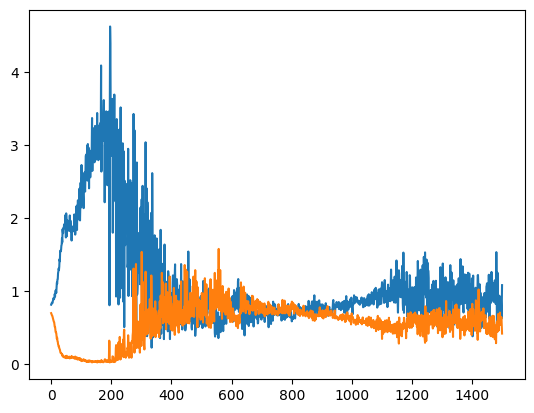

In [5]:
plt.plot(np.arange(len(losses['G'])), losses['G'])
plt.plot(np.arange(len(losses['D'])), losses['D'])

In [6]:
torch.save(generator.state_dict(), "../models/classical_generator.dict")